# Aligning and clustering sequences with Plasmid
This notebook illustrates the various functions contained in the `aligner`, `cluster`, and `fileIO` modules, which can be used to read, align, cluster sequences, and search databases.

## Table of Contents
1. [Reading fastq or fasta files](#read_fastq)
1. [Aligning NGS reads against reference sequences](#read_alignment)
1. [Computing pairwise distance between sequences](#distance_matrix)
1. [Clustering sequences](#clustering)
2. [Performing Multi-alignment](#multi_alignment)
3. [Viewing CIGAR alignments](#cigar_alignment)

In [1]:
import numpy as np
import pandas as pd
import plasmid as pge
import seaborn as sns
import matplotlib.pyplot as plt

<a class="anchor" id="read_fastq"></a>
## Reading fastq or fasta sequences
`fileIO` module contains functions for reading compressed or uncompressed fasta or fastq files. These functions take a filename and returns the contents as a pandas dataframe for processing in python.

In [2]:
help(pge.fileIO.read_fastx)
help(pge.fileIO.read_fasta)

Help on function read_fastx in module plasmid.fileIO:

read_fastx(fname)
    Reads data from fasta or fastq
    returns filename

Help on function read_fasta in module plasmid.fileIO:

read_fasta(fname)
    Reads list of sequences from a fasta file format
    fname = file to read the information
    returns list of sequence and names



In [3]:
# Loads raw nanopore fastq reads
x = pge.fileIO.read_fastx('../data/pseudo_ref.fq.bz2')
print('These are nanopore reads')
print(x.iloc[:5])

ref = pge.fileIO.read_fasta('../data/ref_db.fa')¶
# Selections for only sequences with HAP in the header
ref = ref[ref['name'].str.contains('HAP')]
print('These are reference sequences in a fasta file')
print(ref.iloc[:5])

These are nanopore reads
                                              name   
0   0009eaed-04ca-48d8-9942-8ec3eec3582e_rs145_908  \
1   0040c447-47cc-4c26-8b77-341cd361ad4e_rs214_998   
2  0050ef5b-3d85-4985-b1f9-77044e482836_rs277_1015   
3   00651788-a8e3-4a64-9502-6f5a834fd93a_rs136_919   
4  006c811e-a5ae-4a9a-966d-d5586438b326_rs351_1055   

                                            sequence   
0  GGCTCGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGGTGAC...  \
1  TGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTCTGTGGGT...   
2  TGGCTCCGGGTAGTGTCTCAATGATGGAGTGCTGTAAGCTTCAGGG...   
3  TGGCTCAGGTGTCTCAATGATGGAGATTACTGTAGAAAAGCACTAA...   
4  TGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACCTAGGGTGA...   

                                             quality  
0  '($%')1141.+-3/-52455132/-.,)*((.)')'%')1,'**,...  
1  /55/'%().)-+-+*1.**)*3,+)),()'*+('0.*)'(&&+432...  
2  %&0***/+0('$$%%+))+%**'(***'&'&),--..(,.12/04-...  
3  0,0/01&.)((*+4)3)((232/*))-)+,-,.+'+*-+%'%(*.*...  
4  -023))&+*257--,8,475.-4133724122/.0

<a class="anchor" id="read_alignment"></a>
## Aligning NGS reads
`Aligner` module contains many wrapper functions for running popular alignment tools such as [bwa](https://github.com/lh3/bwa), [minimap2](https://lh3.github.io/minimap2/minimap2.html), and [bowtie2](https://github.com/BenLangmead/bowtie2) from jupyter notebook. Indices are stored in temporary directories. The alignment results are written to disk, executed with subprocess calls, and results read back into pandas dataframe. The purpose of the wrapper functions is to accelerate prototyping of custom analysis methods for sequence data.

In [4]:
help(pge.Aligner.minimap2)
print('Alignment parameters for minimap2')
print(pge.Aligner.params['minimap'])

Help on function minimap2 in module plasmid.aligner:

minimap2(self, query, query2=None, database=None)
    This is a wrapper for the minimap2 aligner.
    This aligner is better suited for long reads (>100bp) from nanopore sequencing
    
    query = list of sequences to search for in database
    query2 = reverse pair of paired end read
    
    query and query2 must be in pandas dataframe format with columns:
    [name, sequence] or [name, sequence, quality]
    
    database = database of sequences being search through
    
    database must be in pandas dataframe format with columns:
    [name, sequence] or [name, sequence, quality]
    or a string containing the filename of the fn_index
    
    returns a pandas dataframe of alignment results from the paf file

Alignment parameters for minimap2
{'k': 7, 'w': 1, 'config': '-x map-ont -P', 'cigar': True}


`k` kmer size for the kmer computation. Smaller is better for sensitivity at the cost of speed.

`w` window stride for the kmer computation. Smaller is better for sensitivity at the cost of speed.

`config` defines other parameters to pass to the minimap2 commandline application.

`cigar` boolean flag to compute the cigar string.

These above parameters affect the alignment results obtained with minimap2.

### Running minimap2 to compute alignment to reference sequences
The following code blocks compute the accuracy of nanopore reads aligned against reference sequences. Minimap2 is used to perform the alignment.

In [33]:
def getacc(qry, ref):
    '''
    Computes the accuracy of reads relative to the reference sequences they were derived from
    '''
    # initialize the aligner
    aln = pge.Aligner()
    # all minimap2
    df = aln.minimap2(query=qry, database=ref)
    # filter alignments to the best matching results for each pair of reads
    df = pge.Aligner.filter_idx(df, ['query_id'], 'AS', 'idxmax')
    df = df.rename(columns={'query_id':'name'})
    # merge sequences to the query reads
    qry = qry.merge(df[['name','database_id','match_score','similarity']], how='left', on='name')
    return qry

In [6]:
x['length'] = [len(i) for i in x.sequence]
df = getacc(x, ref)

[M::mm_idx_gen::0.002*1.30] collected minimizers
[M::mm_idx_gen::0.003*1.88] sorted minimizers
[M::main::0.003*1.88] loaded/built the index for 50 target sequence(s)
[M::mm_mapopt_update::0.004*1.83] mid_occ = 88
[M::mm_idx_stat] kmer size: 7; skip: 1; is_hpc: 0; #seq: 50
[M::mm_idx_stat::0.004*1.80] distinct minimizers: 5565 (26.92% are singletons); average occurrences: 5.830; average spacing: 1.011; total length: 32786
[M::worker_pipeline::20.086*2.97] mapped 5601 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x map-ont -P -c -k 7 -w 1 -o /tmp/aligner_ru_npx36/results.paf /tmp/aligner_ru_npx36/database.fa /tmp/aligner_ru_npx36/read1.fq
[M::main] Real time: 20.090 sec; CPU: 59.609 sec; Peak RSS: 0.240 GB


/tmp/ipykernel_2025802/669087145.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


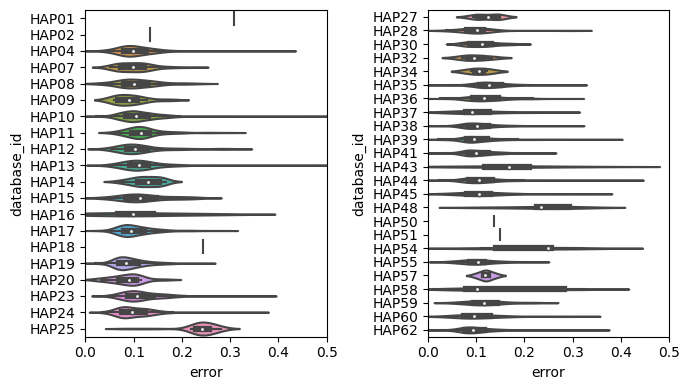

In [7]:
df = df.dropna()
df['error'] = 1-df['similarity']
df = df.sort_values(by=['database_id'])
df['h'] = [int(i.split('HAP')[-1]) for i in df.database_id]
c = df['h'] > 25

plt.figure(1, figsize=(7,4))
plt.title('Accuracy of raw nanopore reads')
plt.subplot(1,2,1)
sns.violinplot(data=df[~c], x='error', y='data¶base_id')
plt.xlim([0,0.5])

plt.subplot(1,2,2)
sns.violinplot(data=df[c], x='error', y='database_id')
plt.xlim([0,0.5])

plt.tight_layout()
#plt.savefig('error.png')
plt.show()

<a class="anchor" id="raw_read_error"></a>
The above plot shows the raw error rate of nanopore reads computed by aligning the reads against their reference sequences. This was possible because the references are at least 15% divergent from each other, which is at the limit of sequence corruption for nanopore reads.

<a class="anchor" id="distance_matrix"></a>
## Computing pairwise distance between sequences
The following code blocks can be used to compute the pairwise distance between a set of sequences. In this example, we use functions contained within the `Clust` module.

In [8]:
help(pge.Clust.get_distance_matrix)

Help on function get_distance_matrix in module plasmid.cluster:

get_distance_matrix(self, query, database)
    Compute the distance matrix for a set of sequences
    query = dataframe with columns [name, sequence]
    database = dataframe with columns [name, sequence]
    return dictionary with 
            'matrix' as adjacency matrix of sequence similarity
            'columns' names of sequences representing each column



In [9]:
clst = pge.Clust()
clst.params['minimap']['config'] = '-x map-ont -P'
df = clst.get_distance_matrix(ref, ref)

[M::mm_idx_gen::0.006*1.32] collected minimizers
[M::mm_idx_gen::0.007*1.58] sorted minimizers
[M::main::0.007*1.58] loaded/built the index for 50 target sequence(s)
[M::mm_mapopt_update::0.008*1.56] mid_occ = 88
[M::mm_idx_stat] kmer size: 7; skip: 1; is_hpc: 0; #seq: 50
[M::mm_idx_stat::0.008*1.55] distinct minimizers: 5565 (26.92% are singletons); average occurrences: 5.830; average spacing: 1.011; total length: 32786
[M::worker_pipeline::0.214*2.85] mapped 50 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x map-ont -P -c -k 7 -w 1 -o /tmp/clust_cltu_36t/results.paf /tmp/clust_cltu_36t/database.fa /tmp/clust_cltu_36t/read1.fa
[M::main] Real time: 0.214 sec; CPU: 0.610 sec; Peak RSS: 0.707 GB


Converting paired list to adjacency matrix


<Figure size 500x300 with 0 Axes>

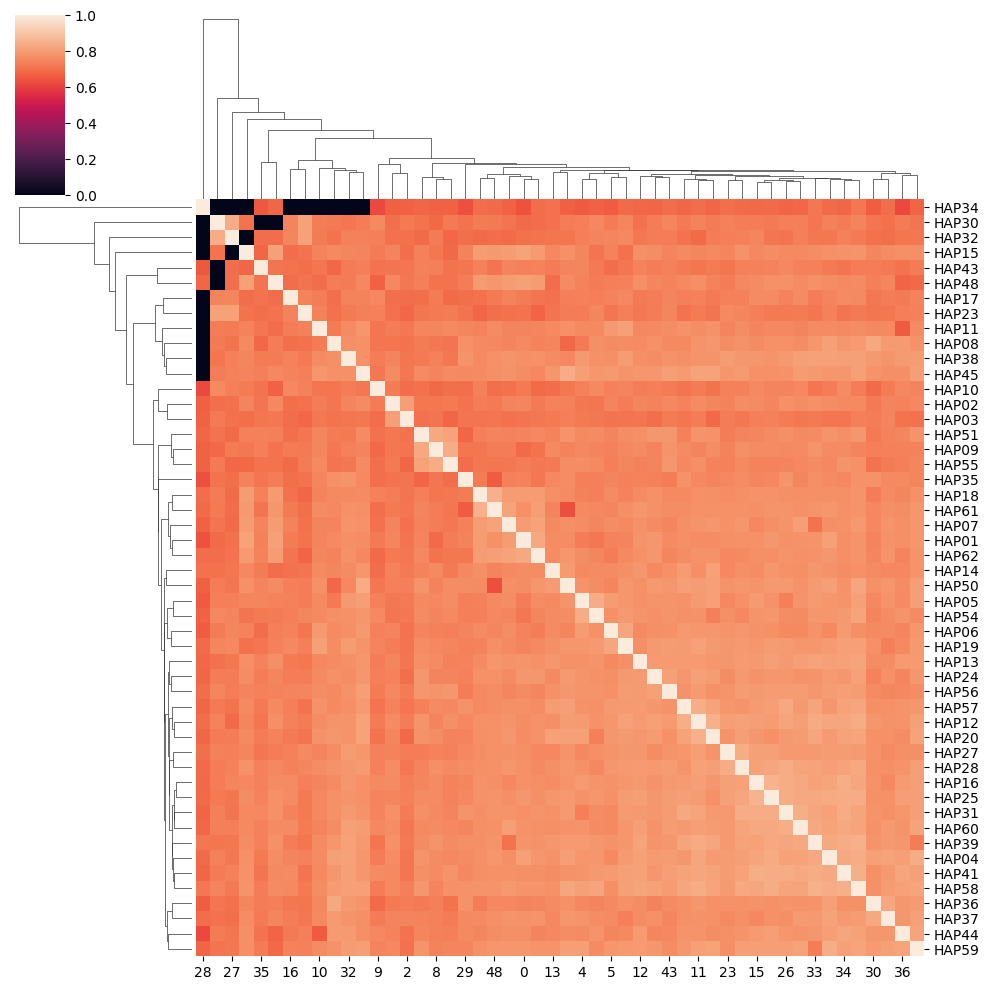

In [10]:
plt.figure(1, figsize=(5,3))
# display only first 30 columns
ylabel = df['columns']
sns.clustermap(data=1-df['matrix'], yticklabels=ylabel)
#plt.savefig('dendrogram.png')
plt.show()

The above clustermap shows the degree of similar between each reference sequence. We can use the `Aligner` module to compute pairwise distances and plot their distribution.

In [11]:
aln = pge.Aligner()
aln.params['minimap']['config'] = '-x map-ont -P'
aln.params['minimap']['k'] = 7
aln.params['minimap']['w'] = 1
df = aln.minimap2(query=ref, database=ref)

[M::mm_idx_gen::0.002*1.29] collected minimizers
[M::mm_idx_gen::0.003*1.87] sorted minimizers
[M::main::0.003*1.87] loaded/built the index for 50 target sequence(s)
[M::mm_mapopt_update::0.004*1.82] mid_occ = 88
[M::mm_idx_stat] kmer size: 7; skip: 1; is_hpc: 0; #seq: 50
[M::mm_idx_stat::0.004*1.78] distinct minimizers: 5565 (26.92% are singletons); average occurrences: 5.830; average spacing: 1.011; total length: 32786
[M::worker_pipeline::0.209*2.89] mapped 50 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x map-ont -P -c -k 7 -w 1 -o /tmp/aligner_0fioablb/results.paf /tmp/aligner_0fioablb/database.fa /tmp/aligner_0fioablb/read1.fa
[M::main] Real time: 0.209 sec; CPU: 0.603 sec; Peak RSS: 0.707 GB


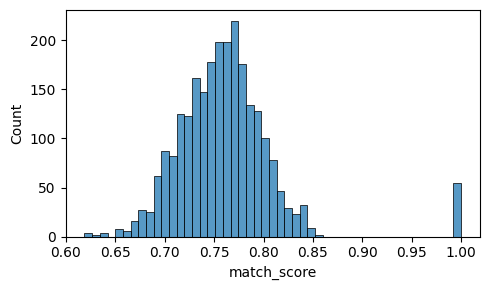

In [12]:
plt.figure(1, figsize=(5,3))
sns.histplot(data=df, x='match_score')
#plt.savefig('histogram.jpg')
plt.tight_layout()
plt.show()

The plot above shows how the reference sequences are at least 15% divergent from each other. Samples with 100% match_score are sequences aligned to themselves.

<a class="anchor" id="clustering"></a>
## Clustering sequences
`Clust` module contains a novel method for clustering sequences based on density. This algorithm is called optics. It can compute sequence cluster using pairwise distance information. This function combines functionality from `Aligner.minimap` to compute pairwise distances and `sklearn` to compute clusters using the optics density based clustering algorithm.

In [13]:
help(pge.Clust.optics_sequence)
print('Parameters associated with optics')
print(pge.Clust.params['optics'])

Help on function optics_sequence in module plasmid.cluster:

optics_sequence(self, qry)
    Find cluster centers for a set of sequences using OPTICS
    qry = dataframe of query sequences to search for cluster centers
           Must have at least the following columns:
           [name, sequence]
    csize = number of sequences to take from cluster center for multi-seq alignment

Parameters associated with optics
{'min_samples': None, 'min_cluster_size': None, 'xi': 0.05, 'max_eps': None, 'cluster_method': 'dbscan', 'n_jobs': None, 'alt_label': False}


### Running optics sequence clustering
The following code blocks loads raw nanopore reads and clusters the reads using optics.

In [15]:
# Read nanopore data
x = pge.fileIO.read_fastx('../data/pseudo_ref.fq.bz2')

clst = pge.Clust()
aln.params['minimap']['config'] = '-x map-ont -P'
aln.params['minimap']['k'] = 15
aln.params['minimap']['w'] = 2
df = clst.optics_sequence(x)

cluster_compute: computing pairwise distance matrix


[M::mm_idx_gen::0.141*1.00] collected minimizers
[M::mm_idx_gen::0.214*1.68] sorted minimizers
[M::main::0.214*1.68] loaded/built the index for 5601 target sequence(s)
[M::mm_mapopt_update::0.229*1.64] mid_occ = 435
[M::mm_idx_stat] kmer size: 15; skip: 2; is_hpc: 0; #seq: 5601
[M::mm_idx_stat::0.238*1.61] distinct minimizers: 880857 (78.60% are singletons); average occurrences: 3.113; average spacing: 1.506; total length: 4130106
[M::worker_pipeline::16.225*2.97] mapped 5601 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -D --dual=no --for-only -c -k 15 -w 2 -o /tmp/clust_4nmg8s0c/results.paf /tmp/clust_4nmg8s0c/database.fq /tmp/clust_4nmg8s0c/read1.fq
[M::main] Real time: 16.233 sec; CPU: 48.213 sec; Peak RSS: 0.707 GB


Converting paired list to adjacency matrix
Running clust_OPTICS
max_eps = 0.5
clust_OPTICS: iter=0 using min_samples=2783


/home/zchen/Public/python/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


clust_OPTICS: clusters=0 outliers=5566 delta=1391.5
clust_OPTICS: iter=1 using min_samples=1392


/home/zchen/Public/python/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


clust_OPTICS: clusters=0 outliers=5566 delta=1391
clust_OPTICS: iter=2 using min_samples=697


/home/zchen/Public/python/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


clust_OPTICS: clusters=0 outliers=5566 delta=695
clust_OPTICS: iter=3 using min_samples=350


/home/zchen/Public/python/lib/python3.11/site-packages/sklearn/cluster/_optics.py:598: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


clust_OPTICS: clusters=0 outliers=5566 delta=347
clust_OPTICS: iter=4 using min_samples=177
clust_OPTICS: clusters=4 outliers=4644 delta=173
clust_OPTICS: iter=5 using min_samples=91
clust_OPTICS: clusters=9 outliers=3221 delta=86
clust_OPTICS: iter=6 using min_samples=48
clust_OPTICS: clusters=15 outliers=1852 delta=43
clust_OPTICS: iter=7 using min_samples=27
clust_OPTICS: clusters=18 outliers=570 delta=21
clust_OPTICS: iter=8 using min_samples=17
clust_OPTICS: clusters=13 outliers=240 delta=10
clust_OPTICS: iter=9 using min_samples=32
clust_OPTICS: clusters=17 outliers=728 delta=5
clust_OPTICS: iter=10 using min_samples=39
clust_OPTICS: clusters=17 outliers=1260 delta=-7
clust_OPTICS: iter=11 using min_samples=39
clust_OPTICS: clusters=17 outliers=1260 delta=-7
clust_OPTICS: iter=12 using min_samples=42
clust_OPTICS: clusters=16 outliers=1318 delta=-3
clust_OPTICS: iter=13 using min_samples=37
clust_OPTICS: clusters=16 outliers=1031 delta=-2
clust_OPTICS: iter=14 using min_samples=3

In [17]:
df.to_csv('clusters.csv.gz',index=False)
df

,name,labels,ordering,reachability,sequence,quality
0,0009eaed-04ca-48d8-9942-8ec3eec3582e_rs145_908,-1,0,0.423341,GGCTCGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGGTGAC...,"'($%')1141.+-3/-52455132/-.,)*((.)')'%')1,'**,..."
1,00178678-f672-4093-aaf0-d7ba9f30619a_rs103_887,-1,1,0.423341,TGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTCAGGGTGA...,"$/13&&(,'/341)(.-),/.01-*+*'-,+/.55*).+,/7424,..."
2,001cfb60-9530-4ef5-afe3-ca652fd4afa1_rs84_864,-1,2,0.423341,TGGCTCAGGTGTCTCAATGATGAAGTGGAGATTACTGTAAACTTCA...,"/353-+*)&,)---+.*($&($'&&',0)&(+)*+,*224/,...,..."
3,0040c447-47cc-4c26-8b77-341cd361ad4e_rs214_998,-1,3,0.423341,TGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTCTGTGGGT...,"/55/'%().)-+-+*1.**)*3,+)),()'*+('0.*)'(&&+432..."
4,0050ef5b-3d85-4985-b1f9-77044e482836_rs277_1015,-1,4,0.423341,TGGCTCCGGGTAGTGTCTCAATGATGGAGTGCTGTAAGCTTCAGGG...,"%&0***/+0('$$%%+))+%**'(***'&'&),--..(,.12/04-..."
...,...,...,...,...,...,...
5561,ffe46913-9afb-4fa5-b8c7-5ec012b66fb6_rs176_967,13,5119,0.152284,TGGCTCAGGTGCTCTCAATGATGGAGATTACTGTAAACTTCAGGGT...,",+6221--,*))-,-)+('&%%'%%%%-&()..,,/),,0-(/0+)..."
5562,ffedc494-0b0e-4576-82af-4394fc8aba7a_rs81_839,9,4181,0.179198,TGGCTCAGGGTGTCTCAGTGGGAATTACTATAAACTTCAGGGTGAC...,"'&*-,.&+)+,3340)&%&&&%%#-$$$&%).+))--0,-2.+-.1..."
5563,fff6cc1e-a41d-4e5f-9719-b8baf12f84ee_rs211_939,-1,5565,0.423341,TGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTTAGGTGAC...,",0/,**)3*01/..-0,*-**1/.+,+2*)'%%,0*(,&%&,'+-*..."
5564,fff87e67-f753-4f13-89d8-ef784a673e81_rs225_997,8,3864,0.129353,TGGCTCGTGTCTCAATGATGGAGATTGATTGTAAACTTCAGGGTGA...,")2.(&%.*40++*-&'-+,,/,+*+)&(%'%%04.))/(*)2+)(&..."


In [20]:
# get accuracy of the raw reads by aligning against the reference sequences
aln = pge.Aligner()
aln.params['minimap']['config'] = '-x map-ont'
aln.params['minimap']['k'] = 7
aln.params['minimap']['w'] = 1
acc = aln.minimap2(query=df, database=ref)
acc = pge.Aligner.filter_idx(acc, ['query_id','database_id'],'AS','idxmax')

[M::mm_idx_gen::0.002*1.30] collected minimizers
[M::mm_idx_gen::0.003*1.88] sorted minimizers
[M::main::0.003*1.88] loaded/built the index for 50 target sequence(s)
[M::mm_mapopt_update::0.004*1.84] mid_occ = 88
[M::mm_idx_stat] kmer size: 7; skip: 1; is_hpc: 0; #seq: 50
[M::mm_idx_stat::0.004*1.81] distinct minimizers: 5565 (26.92% are singletons); average occurrences: 5.830; average spacing: 1.011; total length: 32786
[M::worker_pipeline::8.181*2.99] mapped 5566 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x map-ont -c -k 7 -w 1 -o /tmp/aligner_syjvq8s6/results.paf /tmp/aligner_syjvq8s6/database.fa /tmp/aligner_syjvq8s6/read1.fq
[M::main] Real time: 8.181 sec; CPU: 24.496 sec; Peak RSS: 1.251 GB


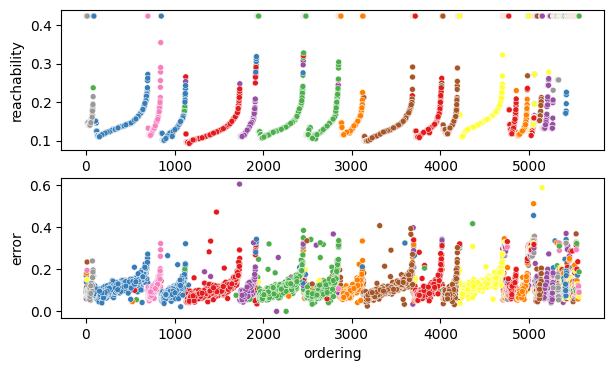

In [24]:
acc = acc.rename(columns={'query_id':'name'})
df2 = df.merge(acc[['name','match_score','database_id']], how='left', on='name')
df2['error'] = 1-df2['match_score']

plt.figure(1,figsize=(7,4))
plt.subplot(2,1,1)
sns.scatterplot(data=df2, x='ordering',y='reachability', hue='database_id', palette='Set1', size=1)
ax = plt.gca()
ax.get_legend().remove()

plt.subplot(2,1,2)
sns.scatterplot(data=df2, x='ordering',y='error', hue='database_id', palette='Set1', size=1)
ax = plt.gca()
ax.get_legend().remove()

The top plot shows the ordering produced by optics vs reachability. Reachability is a measure of the density at a data point within a cluster. Each of the curves represents an individual sequence cluster found via optics density based clustering. The data points are colorized by the true haplotype identity, which was determined via alignment of the raw reads against the reference sequences from which the dataset was derived.

The bottom plot shows the error relative to the reference sequences vs optics ordering. From comparing the top and bottom plots, we can see there is a strong correlation between the reachability metric and error relative to reference sequences. This means the optics clustering algorithm was able to cluster and order highly errored nanopore reads in such a way that highly accurate reads end up in the cluster centers.

<a class="anchor" id="multi_alignment"></a>
## Performing multi-sequence alignment
The following section shows how multi-sequence alignment can be performed on a set of sequences. In nanopore sequencing, multi-sequence alignment can be used to average out sequencing errors and recover a high fidelity measure of the originating amplicon.

In [128]:
help(pge.Aligner.spoa)
print('Parameters for multi-alignment with spoa')
print(pge.Aligner.params['spoa'])

Help on function spoa in module plasmid.aligner:

spoa(self, seq)
    Runs multi-sequence alignment on provided sequences with spoa
    seq = list of sequences
    returns dictionary containing {'consensus':sequence, 'msa':<list of sequences>}

Parameters for multi-alignment with spoa
{'algorithm': 2, 'genmsa': True, 'm': 5, 'n': -4, 'g': -8, 'e': -6, 'q': -10, 'c': -4}


`Aligner` module can use spoa to perform multi-sequence alignment. Details on the parameters associated with the spoa algorithm can be found on the [spoa](https://github.com/rvaser/spoa) github page. The code below perform multi-sequence alignment on one single cluster from the optics algorithm.

In [139]:
# initialize aligner object
aln = pge.Aligner()
aln.params['spoa']['algorithm'] = 2

# load data from optics and perform multi-alignment via spoa
x = pd.read_csv('clusters.csv.gz')
# selection cluster 0
c = x['labels'] == 0

# perform multi-alignment on sequences
msa = aln.spoa(x[c]['sequence'].values)

### Visualizing multi-alignments
`.colorize_msa` can also be used to visualize minor variants in the multi-alignment that differe from the consensus sequence.

In [140]:
help(pge.Aligner.colorize_msa)

Help on function colorize_msa in module plasmid.aligner:

colorize_msa(msa, width=100, cmap=None)
    Returns a multi-sequence alignment formatted 
    to a certain width
    msa = list of sequences
    width = characters per line
    cmap = colormap from characters to colors
    returns a string output



In [144]:
# Visualize the multi-alignment of the first 75bp of the first 10 sequences
L = 75
seqlist = [s[:L] for s in msa['msa']]
out = pge.Aligner.colorize_msa(seqlist[:10])
print('visualizing the multi-alignment')
print(out)
print('this is the consensus sequence')
print(msa['consensus'][:L])

visualizing the multi-alignment
TGGCTC-G-GGTGT-TC-----AATG-AT-GAG--A-CATT-GT---AAACTT--CAG-GGTGA--CC-AAAGA- 75 seq0
TGGCTC-A-GGTGTCTC-----AATG-ATGGAG--ATTACT-GT---AAACTT--CAG-GGTGA---C-AA--A- 75 seq1
TGGCTC---GGTGTCTC----AAATG-AT-GAG--ATTACT-GT---AAACTT--CAG-GGTGACTCC-AAAGA- 75 seq2
TGGCTC-A-GGTGTCTC-----AATG-ATGGA---ATTACT-GT---AAACTT--CAG-GGTGA--CC-AAA-A- 75 seq3
TGGCTC---GGTGTCTC-----AATG-ATGGAG--ATTACT-GT---AAACTT--CA--TAAGA--CC-AAA-A- 75 seq4
TGGCTC-A-GGTGTCTC-T--CAATG-ATGGGGA-ATTACT-GT---AAGC----CAG-GGTGA--CC-AAAGA- 75 seq5
TGGCTC-G-GGTGTCTC-----AATG-ATGGAG--ATTAT---C---AAACTC--TAG-GGTGA--CC-AAA-A- 75 seq6
TGGCTC-A-GGTGTCTC----CAATG-ATGGA---ATTACT-GT---AAACTT--CAG-GGTGA--CC-AAAGG- 75 seq7
TGGCTC----GCGTCTC-----AATG-ATGGAG--ATTAC--GTA--AAACTC--TGT-AGTGA--CC-AA--A- 75 seq8
TGGCTC-G-GGTGTCTC-TAACAATG-ATGGAG--ATTACT-GT---AAACTC--TA--GGTGA--CC-AAAAA- 75 seq9

this is the consensus sequence
TGGCTCAGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGGTGACCAAAGAATCAAAATAAGTGTTGATAAA


### Obtaining highly accurate nanopore reads via multi-alignment
The code below illustrates how the basic tools in this library can be used to prototype a bioinformatic algorithm or pipeline. Here, errors from individual nanopore reads will be averaged out via multi-alignment of sequences obtained via optics [clustering](#clustering) to recover a highly accurate approximation of the originating amplicon.

In [34]:
# load data from clustering
df = pd.read_csv('clusters.csv.gz')

# initialize the aligner
aln = pge.Aligner()
aln.params['spoa']['algorithm'] = 2

# compute multi-alignment for each cluster for the first 30 sequences
out = []
L = np.max(df['labels'])
for i in range(L):
    # select sequences from each cluster
    x = df[df['labels']==i]
    seq = x['sequence'].values
    # perform multi-alignment on first 30 sequences
    seq = seq[:40]
    msa = aln.spoa(seq)
    val = ['cluster_'+str(i), msa['consensus'], len(seq)]
    out.append(val)
# format into a dataframe
col = ['name','sequence','N']
qry = pd.DataFrame(out, columns=col)

In [36]:
# compute accuracy relative to the reference
ref = pge.fileIO.read_fasta('../data/ref_db.fa')
# Selections for only sequences with HAP in the header
ref = ref[ref['name'].str.contains('HAP')]

# initialize the aligner
aln = pge.Aligner()
# align against the reference
df = aln.minimap2(query=qry, database=ref)
# filter alignments to the best matching results for each pair of reads
df = pge.Aligner.filter_idx(df, ['query_id'], 'AS', 'idxmax')

[M::mm_idx_gen::0.002*1.29] collected minimizers
[M::mm_idx_gen::0.004*1.86] sorted minimizers
[M::main::0.004*1.86] loaded/built the index for 50 target sequence(s)
[M::mm_mapopt_update::0.004*1.81] mid_occ = 88
[M::mm_idx_stat] kmer size: 7; skip: 1; is_hpc: 0; #seq: 50
[M::mm_idx_stat::0.004*1.78] distinct minimizers: 5565 (26.92% are singletons); average occurrences: 5.830; average spacing: 1.011; total length: 32786
[M::worker_pipeline::0.083*2.67] mapped 17 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x map-ont -P -c -k 7 -w 1 -o /tmp/aligner_e8py3asx/results.paf /tmp/aligner_e8py3asx/database.fa /tmp/aligner_e8py3asx/read1.fa
[M::main] Real time: 0.084 sec; CPU: 0.223 sec; Peak RSS: 0.356 GB


In [37]:
qry = qry.rename(columns={'name':'query_id'})
df = df.merge(qry, on='query_id',how='left')
df = df.sort_values(by=['database_id'])
df[['query_id','N','database_id','orientation','match_score','CIGAR']]

,query_id,N,database_id,orientation,match_score,CIGAR
8,cluster_16,15,HAP07,-,0.986425,149M1D118M1D98M1D24M4I205M1I61M
5,cluster_13,40,HAP08,-,0.995441,234M1D260M1D129M1D32M
14,cluster_7,40,HAP10,-,0.992401,216M1D77M1D186M2D175M
0,cluster_0,40,HAP12,-,0.990881,178M1D55M1D135M1D236M1D17M1D8M1D23M
6,cluster_14,40,HAP13,-,0.986364,47M1D49M1D51M1D51M1D16M1I66M1I337M1D36M
16,cluster_9,40,HAP17,-,0.998480,471M1D186M
3,cluster_11,40,HAP19,-,0.957252,144M1I320M1I138M1D13M1D36M
9,cluster_2,40,HAP23,-,0.993921,268M1D44M1D52M2D290M
2,cluster_10,40,HAP35,-,0.987441,47M1D130M1D55M1D33M2D69M1D266M1I19M1D10M
1,cluster_1,40,HAP36,-,0.990881,234M1D33M1D142M1D83M1D129M1D7M1D24M


The table above shows that the consensus sequences obtained via multi-alignment are now almost 99% match to the reference sequences from which they were derived. This is a great improvement in error rate compared to the raw error rate from [before](#raw_read_error).

<a class="anchor" id="cigar_alignment"></a>
### Visualizing cigar alignment strings
To view how good the consensus sequences look relative to the reference, we can format the alignments from CIGAR format to pairwise alignments with `.cigar_to_alignment`

In [73]:
help(pge.Aligner.cigar_to_alignment)

Help on function cigar_to_alignment in module plasmid.aligner:

cigar_to_alignment(query: str, ref: str, cigar: str) -> list
    Function to align query and reference strings based on CIGAR string
    
    Args:
        query = query sequence --> this must be relative to how it was used in aligner
        ref = reference sequence
        cigar = CIGAR string from aligner
    
    Returns:
        return [aligned query, aligned reference, alignment ticks]



In [74]:
# load sequence for HAP58
ref_seq = ref[ref['name']=='HAP62'][['sequence']].values[0][0]

# load sequence for cluster_15
col = ['sequence','CIGAR','q_start','q_end']
clst_seq, cigar, s1, s2 = df[df['query_id']=='cluster_3'][col].values[0]
clst_seq = clst_seq[s1:s2]
rev_seq = pge.misc.revcomp(clst_seq)

# get sequences formatted via cigar strings
out = pge.Aligner.cigar_to_alignment(rev_seq, ref_seq, cigar)
out = pge.Aligner.colorize_msa(out[:2])
print(out)

TACTTTATATTTCATTTTTGGTGCTTGATCAGGTATGGTAGGGACTTCATTAAGACTTTTAATTCGAGCCGAGTTAGGTAACCTGGGTTCATTAATTGGG 100 seq0
TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACCTCATTAAGACTTTTAATTCGAGCCGAGTTGGGTAACCCGGGTTCATTAATTGGG 100 seq1
GACGATCAAATTTATAACGTAATCGTAACTGCTCATGCCTTTATTATGATTTTCTTTATAGTGATACCTATTATAATTGGTGGTTTTGG-AATTGGTTAG 200 seq0
GACGATCAAATTTATAACGTAATCGTAACTGCTCATGCCTTTATTATGATTTTTTTTATAGTGATACCTATTATAATTGGGGGTTTTGGAAATTGGTTAG 200 seq1
TCCCTCTGATGTTAGGTGCTCCAGATATAGCATTCCCTCGAATAAACAACATAAGTTTTTGGTTATTGCCTCCTTCTTTAACACTTTT--AGTCTAGAAG 300 seq0
TCCCTCTGATGTTAGGTGCTCCAGATATAGCATTCCCTCGTATAAACAACATAAGTTTTTGGTTATTGCCTCCTTCTTTAACACTTCTCGTGTCTAGAAG 300 seq1
AATTGTTGACGTAGGTGCTGGTACTGGTTGAACTGTTTATCCTCCTTTCGCCGCAAATATCGCCCACGGAGGGTCTTCGGTTGATTTCGCAATTTTTTCT 400 seq0
AATTGTTGACGTAGGTGCTGGTACTGGTTGAACTGTTTATCCTCCTCTCGCCGCAAATATCGCCCACGGAGGGTCTTCGGTTGATTTCGCAATTTTTTCT 400 seq1
TTACACTTGGCTGGTATTTCTTCGATTTTAGGTGCAGTTAATTTTATTACTACAACTATTAATATGCGTAGCCCTGGTATAACCCTAGACCGGATACCAT 500 seq0
TTACACTTGG

The above alignment shows there is high frequency of C-T transitions. This may indicate the nanopore basecaller has greater difficulty distinguishing between the electrical signals of cytosine and thymidine bases. Another possibility is the degradation of cytosine to uracil, which can be mistaken for thymidine during DNA replication.